# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

The purpose of this project is to build a predictive model that can make salary predictions based on given job dispcriptions. With a dataset of 1 million job roles along with their associated salaries, I will follow the data science 4D framework of Define, Discover, Develop and Deploy to find the best model with lowest RMSE. I will load, clean and perform some explorary data analysis(EDA) on the data before continuing the modeling process. The modeling process will involve This script pulls in salary data, builds and tests several predictive models, and then makes salary predictions on test data using the best model

In [ ]:
# Author information
__author__ = "Sheldon Bishop"
__email__ = "planetshell@gmail.com"

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
# Create helper functions that we can use throughout the 4D process

def load_file(file):
    """loads csv to pd dataframe"""
    return pd.read_csv(file)


def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
    """ perform inner join to return only records that are present in both dataframes"""
    return pd.merge(left=df1, right=df2, how="inner", on=key, left_index=left_index, right_index=right_index)


def clean_data(raw_df):
    """ removes rows that contains salary <= 0 or duplicate job IDs"""
    clean_df = raw_df.drop_duplicates(subset="jobId")
    clean_df = clean_df[clean_df.salary>0]
    return clean_df 

def one_hot_encode_feature_df(df, cat_vars= None, num_vars= None):
    """ perform one-hot encoding on all categorical variables and combine results with numerical variables"""
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars]
    return pd.concat([cat_df, num_df], axis=1)

def label_encode_df(df, cat_vars):
    """ perform label encoding on all categorical variables"""
    label_encoder = LabelEncoder()
    for col in df[cat_vars]:
        df[col] = label_encoder.fit_transform(df[col])
    return df
        
def get_target_df(df, target):
    """ returns the target dataframe"""
    return df[target]

# Part 2 - DISCOVER

### ---- 2 Load the data ----

In this section we will use the load_file() helper function to load each file into a Pandas dataframe and examine them. 

In [3]:
# define inputs
train_feature_file = 'data/train_features.csv'
train_target_file = 'data/train_salaries.csv'
test_feature_file = 'data/test_features.csv' 

In [4]:
#load the data into a Pandas dataframe
feature_df = load_file(train_feature_file)
target_df = load_file(train_target_file)
test_df = load_file(test_feature_file)

In [5]:
#Examine feature_df 
feature_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [6]:
#Examine target_df 
target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [7]:
#Examine test_df 
test_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [24]:
#Verify feature_df length and datatypes
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [25]:
#Verify target_df length and datatypes
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [26]:
#Verify test_df length and datatypes
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


All dataframes loaded and length and datatypes verified. We have a total of million rows for each dataframe and each datatype was reviewed.  

### ---- 3 Clean the data ----

In this section, I used the consolidate_data() helper function to merge the feature and target dataframes. I then checked for incorrect datatypes, missing data, duplicate data and any data that appears invalid. I also examined the outliers in target column(salary) for any abnormalities. Finally based on my finding, I used the clean_data() helper function to clean the data  

In [8]:
# Consolidate training data.Merge feature and target dataframes
raw_train_df= consolidate_data(feature_df, target_df, key="jobId",left_index=False, right_index=False) 
raw_train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [9]:
# Examine categorical and numerical variables
raw_train_df.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'salary'],
      dtype='object')

In [10]:
# Identify and store categorical and numerical variables. 
cat_vars = ["companyId", "jobType","degree", "major", "industry"]
num_vars = ["yearsExperience", "milesFromMetropolis"]
target_var = "salary"

In [11]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
raw_train_df.duplicated().sum()

0

In [12]:
# Check for missing data 
missing_data = raw_train_df.isnull()
for column in missing_data.columns.tolist():
    print('column')
    print(missing_data[column].value_counts())
    print("")

column
False    1000000
Name: jobId, dtype: int64

column
False    1000000
Name: companyId, dtype: int64

column
False    1000000
Name: jobType, dtype: int64

column
False    1000000
Name: degree, dtype: int64

column
False    1000000
Name: major, dtype: int64

column
False    1000000
Name: industry, dtype: int64

column
False    1000000
Name: yearsExperience, dtype: int64

column
False    1000000
Name: milesFromMetropolis, dtype: int64

column
False    1000000
Name: salary, dtype: int64



C:\Users\plane\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\plane\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


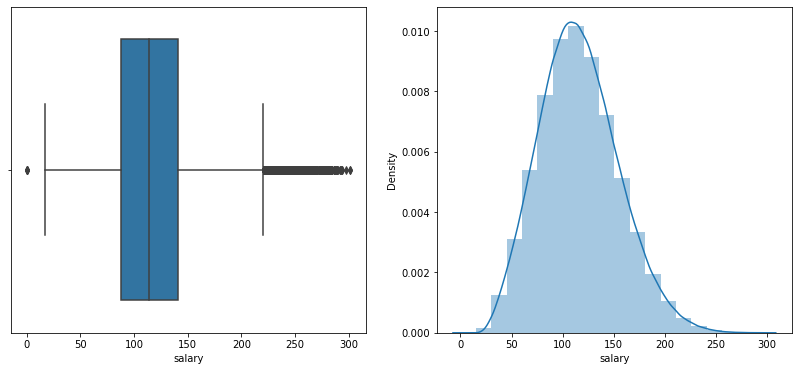

In [60]:
# Summarize and visualize target variable(salary).
# Use the IRQ rule to check outliers for invalid or corrupt data. example..salary<=0
%matplotlib inline 
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(df.salary)
plt.subplot(1,2,2)
sns.distplot(df.salary, bins=20)
plt.show()

In [48]:
# Get statistical data on salary column and use IQR rule to check outliers 
stats = raw_train_df["salary"].describe()
print(stats)
IRQ = stats["75%"] - stats["25%"]
upper = stats["75%"] + 1.5*IRQ
lower = stats["25%"] - 1.5*IRQ
print("The upper and lower bounds for suspected outliers are {} and {}.".format(upper,lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [21]:
# Statistical data shows minimum salary == 0. Check how many rows has salary == 0 (Potential invalid data) 
raw_train_df[raw_train_df["salary"] == 0].salary.value_counts()

0    5
Name: salary, dtype: int64

In [22]:
# Check potential outliers below lower band 
raw_train_df[raw_train_df.salary <= 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [23]:
# Check potential outliers above upper band 
raw_train_df.loc[raw_train_df.salary>220, "jobType"].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [24]:
# Check most suspicious potential outliers above upper bound. 
raw_train_df[(raw_train_df.salary > 220) & (raw_train_df.jobType == "JUNIOR")].head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223


The data cleaning process shows there are no duplicates or missing data.However,statistical analysis on the target column(salary) shows there are 5 rows with 0 salary which indicate invalid data. I removed these rows from the dataset using clean_data(). 

In [13]:
# Clean data and examine dataframe 
clean_df = clean_data(raw_train_df)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   jobId                999995 non-null  object
 1   companyId            999995 non-null  object
 2   jobType              999995 non-null  object
 3   degree               999995 non-null  object
 4   major                999995 non-null  object
 5   industry             999995 non-null  object
 6   yearsExperience      999995 non-null  int64 
 7   milesFromMetropolis  999995 non-null  int64 
 8   salary               999995 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


### ---- 4 Explore the data (EDA) ----

In this section, I summarize each feature variable and the target variable from the cleaned dataframe. I then looked for any correlation between each feature variable and the target variable. 

In [54]:
# Get statistical info on numerical variables
clean_df[num_vars].describe()

,yearsExperience,milesFromMetropolis
count,999995.000000,999995.000000
mean,11.992407,49.529381
std,7.212390,28.877721
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [55]:
# Get statistical info for categorical variables 
clean_df[cat_vars].describe()

,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995
unique,63,8,5,9,7
top,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,16193,125886,236975,532353,143205


In [3]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

In [26]:
#Create function that will summarize each feature variable and target variable

def feature_plot(df, col):
    """ Make plot for each features left,
    the distribution of samples on the feature right, the dependance of salary on the feature"""
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    if df[col].dtype == "int64":
        df[col].value_counts().sort_index().plot()
    else:
        # change the categorical variable to category type and order their level by the mean salary
        # in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype("category")
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels,inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation = 45)
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.subplot(1,2,2)
    
    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df)
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.show()           

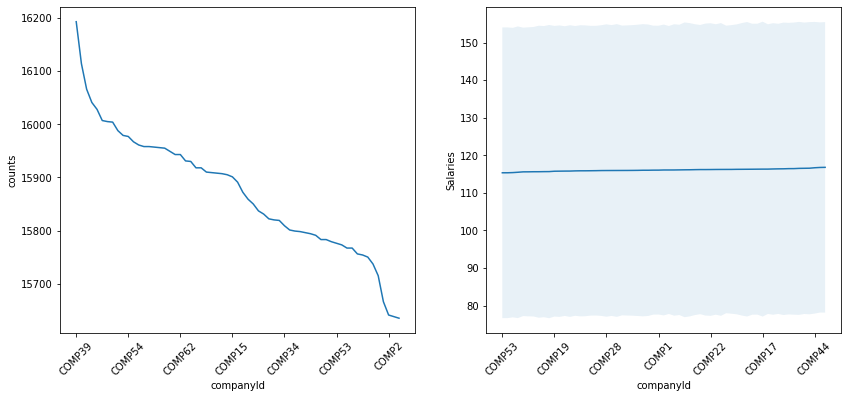

In [27]:
feature_plot(clean_df, "companyId")

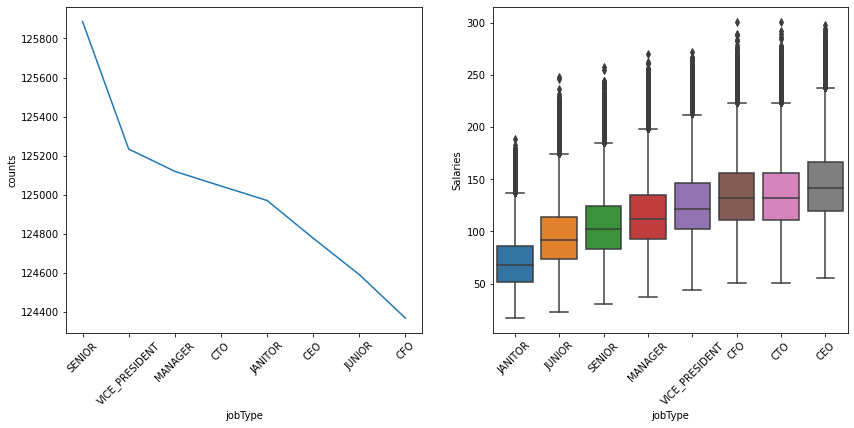

In [36]:
feature_plot(clean_df, "jobType")

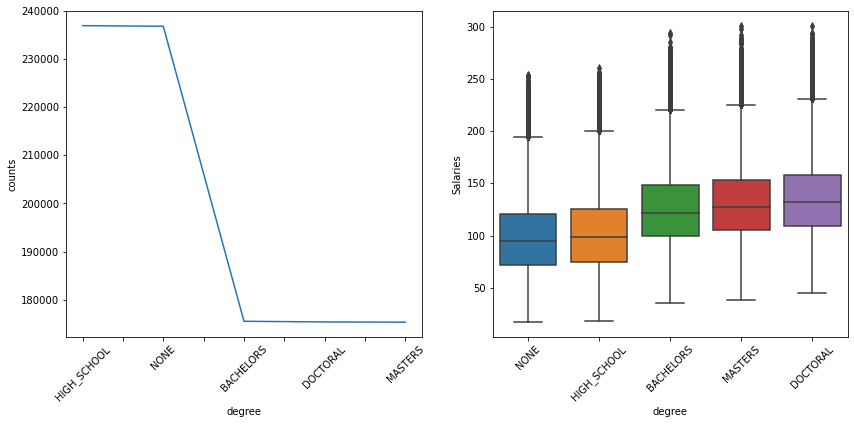

In [37]:
feature_plot(clean_df, "degree")

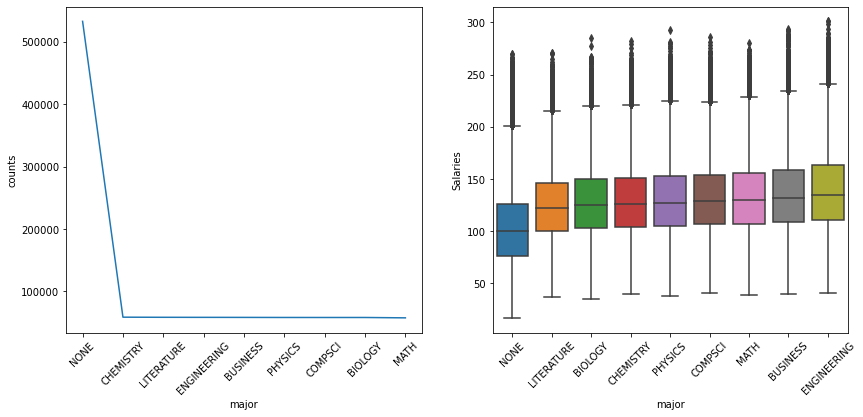

In [38]:
feature_plot(clean_df, "major")

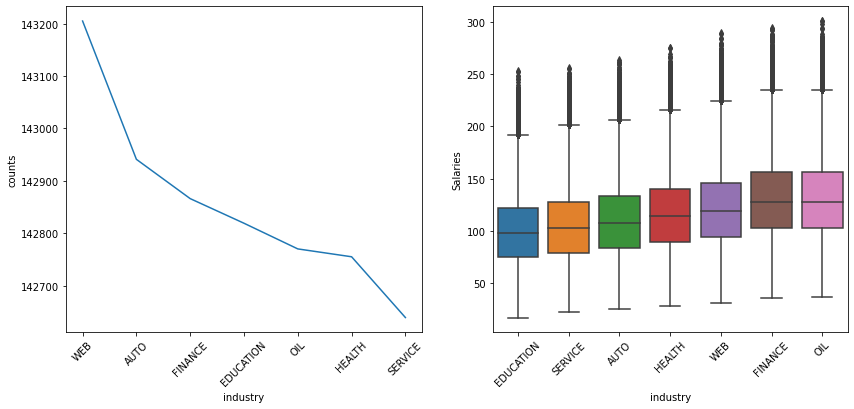

In [39]:
feature_plot(clean_df, "industry")

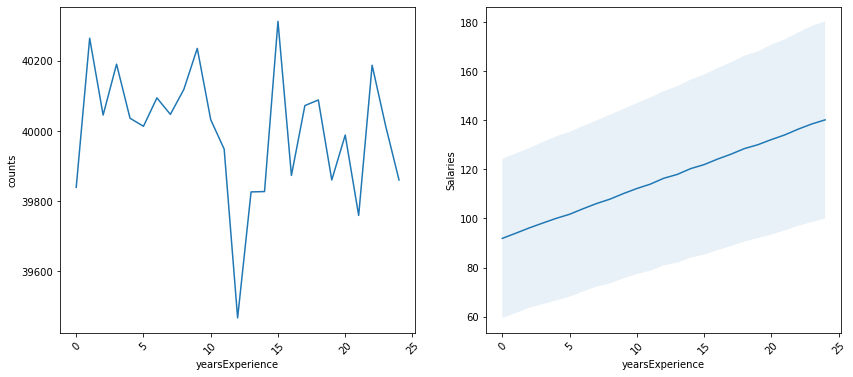

In [40]:
feature_plot(clean_df, "yearsExperience")

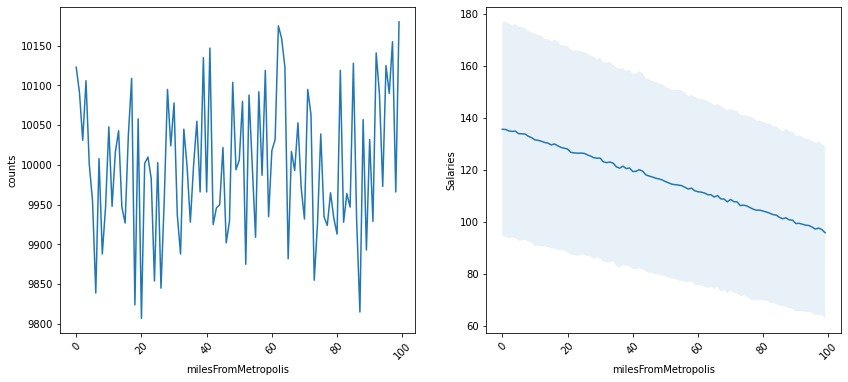

In [41]:
feature_plot(clean_df, "milesFromMetropolis")

The results above show the following:
- No correlation between compandId and salary
- Positive coorelation between jobType and salary. 
- Positive coorelation between degree and salary. 
- Positive coorelation between major and salary 
- Positive coorelation between industry and salary 
- Positive coorelation between yearsExperience and salary 
- Negative coorelation between milesFromMetropolis and salary 

The results above makes sense. In the real world, salaries are generally higher with more advance job roles or more advance degrees.In addition, salaries are generally higher with more years of experience and lower with distance from the city. 

### ---- 5 Establish a baseline ----

In this section I created a simple model that will be the baseline for results from more advance models. The model is create the I used the average salary as the baseline model and measure its efficacy using MSE matrics.       

In [5]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

In [15]:
# Calculate average salary and use as baseline model  
salary_predic = clean_df["salary"].mean()
salary_predic = [salary_predic]*len(clean_df["salary"])
salary_train = clean_df["salary"]

# Find baseline model MSE
mse = mean_squared_error(salary_train,salary_predic)

print("Established average salary as the baseline model and measured its MSE:")
print(salary_predic[0:5])
print("Mean Square Error: {}".format(mse))

Established average salary as the baseline model and measured its MSE:
[116.06239831199156, 116.06239831199156, 116.06239831199156, 116.06239831199156, 116.06239831199156]
Mean Square Error: 1499.0172415563363


### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

The MSE for the baseline model was calculated to be 1499.07. I will use the following models to improve the current baseline model's results. 
- Linear Regression 
- Random Forest Regressor
- Gradient Boost Regressor 

I choose the 3 models above because the problem we are solving is a regression problem. This can be determined by simply examining the relationship between each feature variable and target in the dataset.The EDA show that there are linear relationships between each feature variable and the target. In addition, there's both positive and negative coorelation between the target variable (salary) and feature variables jobType, degree, major, industry, YearsExperience and milesFromMetropolis. 

## Part 3 - DEVELOP

In this section, I created the 3 models using object oriented programming style. 

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

In [16]:
#encode categorical data and get final feature dfs
print("Encoding data")
feature_df = one_hot_encode_feature_df(clean_df, cat_vars=cat_vars, num_vars=num_vars)
test_df = one_hot_encode_feature_df(test_df, cat_vars=cat_vars, num_vars=num_vars)
target_df = clean_df['salary']

Encoding data


In [17]:
feature_df.head()

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,10,83
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,73
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,10,38
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,8,17
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,8,16


### ---- 8 Create models ----

Here I created a model class that I used to test each model.   

In [15]:
#create and tune the models that you brainstormed during part 2

In [18]:
# Create model class with methods and attributes
class model:
    def __init__(self, modelName, feature_df, target_df):
        self.modelName = modelName
        self.feature_df = feature_df
        self.target_df = target_df
        self.mean_mse = None
    
    def cross_validate(self):
        neg_mse = cross_val_score(self.modelName, self.feature_df, self.target_df, cv=4, n_jobs=2, scoring='neg_mean_squared_error')
        self.mean_mse = -1.0*np.mean(neg_mse)
        self.cv_std = np.std(neg_mse)
    
    def print_result(self):
        print('Model test summary \nModel Name: {} \nAverage MSE: {}'.format(self.modelName, self.mean_mse))

### ---- 9 Test models ----

Here I tested all 3 models using 4-fold cross validation and measure the MSE for each model. 

In [19]:
# Test Linear Regression model

""" Create model object then call cross_validate() method """
lr = model(LinearRegression(),feature_df, target_df)
lr.cross_validate()
lr.print_result()

Model test summary 
Model Name: LinearRegression() 
Average MSE: 384.47348528618363


In [20]:
# Test RandomForest Regressor model

""" Create model object then call cross_validate() method """
rf = model(RandomForestRegressor(n_estimators=60, n_jobs=2, max_depth=25, min_samples_split=60,max_features=30, verbose=0), feature_df, target_df)
rf.cross_validate()
rf.print_result()

Model test summary 
Model Name: RandomForestRegressor(max_depth=25, max_features=30, min_samples_split=60,
                      n_estimators=60, n_jobs=2) 
Average MSE: 367.00209377615045


In [21]:
# Test Gradient Boost Regressor model 

gbm = model(GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls', verbose=0), feature_df, target_df)
gbm.cross_validate()
gbm.print_result()

Model test summary 
Model Name: GradientBoostingRegressor(max_depth=5, n_estimators=150) 
Average MSE: 357.06214117057783


### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

Summary results from the first model testing showed that all 3 models show lowered the MSE to below 400. I will apply some feature engineering to help the this result.    

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

In [10]:
feature_df = label_encode_df(clean_df, cat_vars)
test_df = label_encode_df(clean_df, cat_vars)

In [11]:
feature_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,31,1,3,6,3,10,83,130
1,JOB1362684407688,11,0,2,7,6,3,73,101
2,JOB1362684407689,48,7,1,8,3,10,38,137
3,JOB1362684407690,32,5,1,2,0,8,17,142
4,JOB1362684407691,60,7,0,8,2,8,16,163


In [12]:
class FeatureGenerator:
    def __init__(self, feature_df, cat_vars):
        self.feature_df = feature_df
        self.cat_vars = feature_df.cat_vars
        self.groups = feature_df.groupby(cat_vars)["salary"]
    
    def get_group_stats(self):
        """calculates group statistics"""
        group_stats_df = pd.DataFrame({group_stats_df["group_mean"]:self.groups.mean()})
        group_stats_df["group_min"] = self.groups.min()
        group_stats_df["group_max"] = self.groups.max()
        group_stats_df["group_std"] = self.groups.std()
        group_stats_df["group_median"] = self.groups.median()
        
        group_stats_df.reset_index(inplace = True)
        return group_stats_df

    
    def merge_df(self, df2, fillna = False):
        
        """ merges engineered features with original df"""
        df = pd.merge(self.feature_df, df2, how = "left", on = self.cat_vars)
        if fillna:
            df.fillna(0, inplace=True)
        return df
        
    def add_new_col(self, new_col):
        """ add statistical columns to feature df """        

In [13]:
new_feature = FeatureGenerator(feature_df, cat_vars)

AttributeError: 'DataFrame' object has no attribute 'cat_vars'

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data